In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import beta

plot_settings = {'title':14, 'text':12, 'annotation':10, 'figsize':(16,8)}

Por Miguel Ángel Castañeda Martínez.

<div style="text-align: justify">
Cuando empecé mi trayectoria como científico de datos tenía escaso conocimiento de lenguajes de programación, modelos de aprendizaje de máquina, análisis exploratorio de datos, etc. En un inicio imaginaba que la analítica de datos iba más por el camino de los sistemas, el poder computacional, y los algoritmos, pero nunca imaginé que tuviera algo que ver con estadística. Para mí la estadística era una materia más con la que se tenía que cumplir en la carrera, la veía como algo arcaico incluso tedioso. Poco imaginaba que años después terminaría siendo de mis temas favoritos, que encontraría fascinante el inmenso mundo del que se trata, y que me daría cuenta del enorme abanico de aplicaciones que tiene.

En este breve ensayo intento mostrar, con un ejemplo aplicado, las diferencias entre un enfoque frecuentista y un enfoque bayesiano. Cabe destacar que es la opinión de una persona que empieza a adentrarse en el mundo de la estadística bayesiana, que considera que la mejor manera de asimilar el conocimiento es compartiéndolo, y que por tanto está haciendo un esfuerzo por transmitir sus primeras impresiones e intuiciones del tema.

El ejemplo que utilizaré para mostrar los conceptos es con datos de encuestas realizadas para la elección presidencial del 2008 en Estados Unidos, mismos que se pueden encontrar en el portal de [Pew Research Center](https://www.pewresearch.org/). Este ejemplo fue extraido del libro [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf), Andrew Gelman, 3° edición - p. 61, y es una expansión de un trabajo realizado para la materia de [Fundamentos de estadística](https://tereom.github.io/fundamentos-2022/) impartida en la [Maestría en Ciencia de Datos](https://mcdatos.itam.mx/es) del [ITAM](https://www.itam.mx/) , por quien rápidamente se posicionaría como una de las mejores profesoras que he tenido en mi trayectoria profesional, [Teresa Ortiz](https://tereom.netlify.app/)

## El problema

Como es bien sabido, la elección de Estados Unidos en el 2008 la ganó el candidato presidencial por el partido demócrata, Barack Obama. Se podría pensar que existe cierta correlación entre la proporción de votos que recibió Obama, con la proporción de votantes que se identifican liberales en cada estado, por lo que para ilustrar ambos enfoques, se realizará una comparación entre la proporción de la población de cada estado que tiene ideología política "muy liberal" (en lo subsecuente _very liberal_), contra el porcentaje de votos que recibió el candidato en cada estado.

Para hacer dicha comparación se tienen dos conjuntos de datos, el primero de ellos es el de las encuestas realizadas a la ciudadanía del país, para el cual cada registro es una persona encuestada, y son de interés las siguientes variables:

* `state`: Estado en el que se realizó la encuesta.
* `survey`: Identificador de la encuesta aplicada en cada registro.
* `ideo`: Ideología política del encuestado.

El segundo de ellos contiene los resultados de la elección por estado, para el cual el foco de atención estará en las variables a continuación:

* `state`: Estado de referencia.
* `vote_Obama_pct`: Porcentaje de votos por Obama.

</div>

<div style="text-align: justify">

## Enfoque Frecuentista

Para la primera parte del análisis se obtendrá la proporción de la población que se identifica _very liberal_ utilizando un enfoque frecuentista, es decir, se puede obtener la proporción de máxima verosimilitud utilizando una distribución binomial. Para ello, se puede ver a cada uno de los $n$ encuestados de un estado en particular $X = \{x_1,x_2,...,x_n\}$, como $n$ muestras de una variable aleatoria independiente e idénticamente distribuida, y que siguen una distribución $x_i \backsim B(k=1, p=\theta)$, en donde una persona con dicha ideología es considerada como un éxito bajo una binomial.

El estimador de máxima verosimilitud para una distribución binomial bajo $k=1$ está dada por:

$$\theta = \bar x$$

En el caso del ejemplo, se puede obtener dicho estimador de proporción (`prop_mle`) utilizando el total de las encuestas realizadas en un estado (`survey_total`), y el total de encuestados que se identificaron _very liberal_ (`survey_very_lib`) en su ideología política. Esto se observa con mayor detalle en la siguiente tabla, misma que por simplicidad solamente muestra los primeros cinco estados.

**Nota**: La demostración del estimador $\theta$ se puede encontrar en el Anexo 1.

</div>

In [2]:
#Carga de datos de encuestas
poll_data = pd.read_stata('./pew_research_center_june_elect_wknd_data.dta')

#Paso 1: Se agrupa por estado para obtener el número de encuestas realizadas en cada estada
state = poll_data.groupby(by='state').count()
state.reset_index(inplace=True)
state = state[['state', 'survey']]

#Paso 2: Se agrupa por estado e ideología para filtrar encuestas very liberal
ideo = poll_data.groupby(by=['state','ideo']).count()
ideo.reset_index(inplace=True)
ideo = ideo[['state', 'ideo', 'survey']]
very_liberal = ideo.loc[ideo['ideo'] == 'very liberal']

#Paso 3: Se unen los dos conjuntos anteriores
prop = pd.merge(left=state,
                right=very_liberal,
                how='left',
                on='state',
                suffixes=('_total','_very_lib'))

#Paso 4: Se crea obtiene la proporción de very libera de máxima verosimilitud por estado
prop['prop_mle'] = prop['survey_very_lib'] / prop['survey_total']

#Paso 5: Se eliminan estados que no son de interés
prop = prop[~prop['state'].isin(['washington dc', 'hawaii', 'alaska'])]
prop.head()

,state,survey_total,ideo,survey_very_lib,prop_mle
0,alabama,624,very liberal,30,0.048077
1,arizona,542,very liberal,28,0.051661
2,arkansas,307,very liberal,7,0.022801
3,california,2854,very liberal,179,0.062719
4,colorado,468,very liberal,27,0.057692


<div style="text-align: justify">

Algunas cosas que se pueden destacar de la tabla anterior, es que a pesar de que algunos estados pudieran presentar la misma proporción de _very liberal_, no necesariamente representa una cantidad significativa de votantes ya que esto depende de la población de cada estado. Tal es el caso de California comparado con Colorado, en donde porcentualmente tienen proporciones similares con $6.3\%$ y $5.8\%$ respectivamente, pero en el total de encuestas California es mucho mayor.
    
Para tener idea del panorama de la proporción de _very liberal_ comparado con el número de encuestas para cada uno de los estados, se puede realizar la siguiente visualización:

</div>

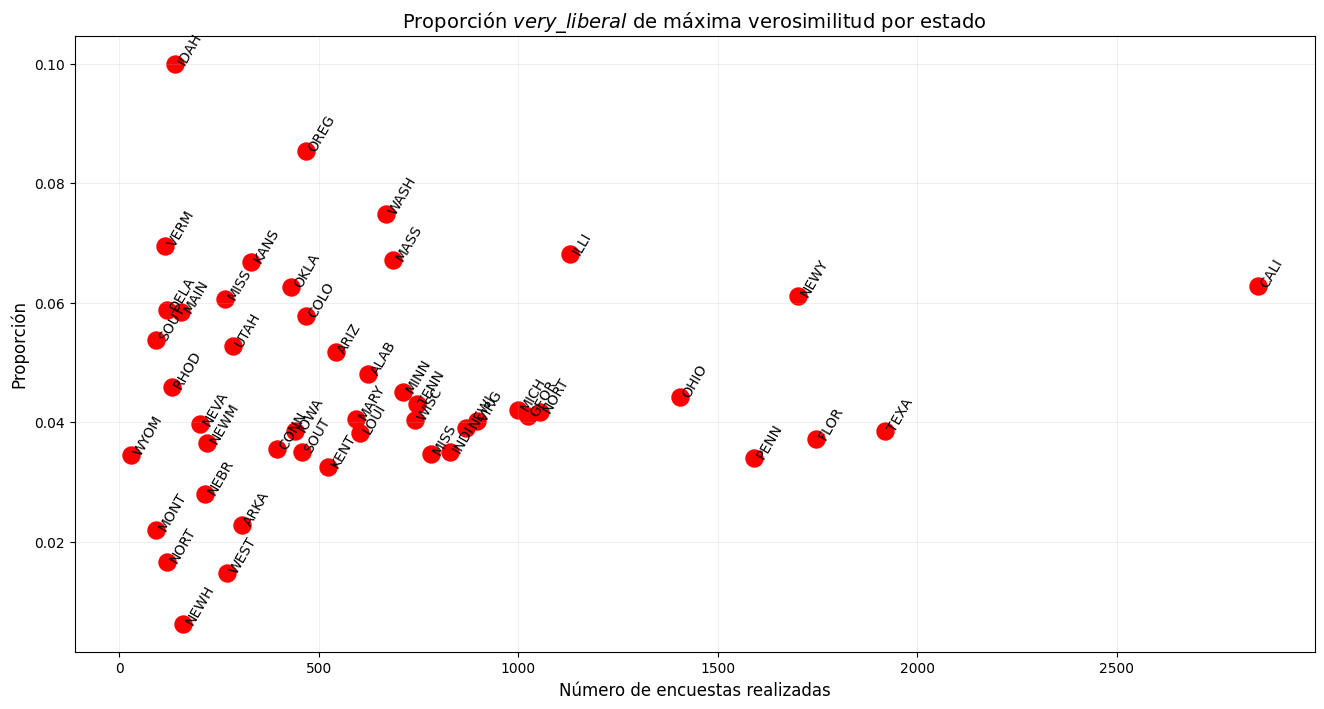

In [3]:
#Scatter plot
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], s=150, color='red')

#Anotaciones y estilo
for idx in prop.index:
    x = prop.loc[idx]['survey_total']
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=plot_settings['annotation'], rotation=60)
plt.title(r'Proporción $very\_liberal$ de máxima verosimilitud por estado', fontsize=plot_settings['title'])
plt.xlabel('Número de encuestas realizadas', fontsize=plot_settings['text'])
plt.ylabel('Proporción', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)

plt.show()

<div style="text-align: justify">

Se puede ver que la proporción de máxima verosimilitud de personas con ideología _very liberal_ no incrementa linealmente con el tamaño de la población, de hecho, si se observa con detenimiento, se puede identificar que estados como California, Nueva York, o Texas, en donde se realizó un mayor número de encuestas, tienden a estar centrados en torno a una proporción del $5\%$. Lo anterior es contrastante con los estados en los que se realizaron menos de 500 encuestas, mismos que tienen mayor dispersión entre sí resultando en una gráfica que tiende a ser un cono que se abre a menor número de encuestas, pero que converge cuando estas aumentan.
    
Lo anterior puede dar una primera intuición de un enfoque frecuentista, y es que bajo esta lupa es razonable pensar que entre mayor sea el tamaño de la muestra, mayor convergencia se tendrá hacia el verdadero valor poblacional. En el caso de la proporción de personas _very liberal_ se podría pensar que cada uno de los estados son una representación del comportamiento general de todo el país, por ende, si en el país la proporción de personas con dicha ideología es del $5\%$, entonces los diferentes estados tendrían que tener proporciones centradas en torno a este valor con una determinada varianza.

Se puede hacer entonces una inspección visual del comportamiento de la proporción de personas _very liberal_ contrastando el porcentaje de votos que recibió Obama. Para ello, primero es necesario recordar la idea inicial del ensayo, es decir, existe cierta correlación entre la proporción de votos que recibió Obama, con la proporción de votantes que se identifican liberales en cada estado. Para ello se puede realizar la siguiente gráfica:

</div>

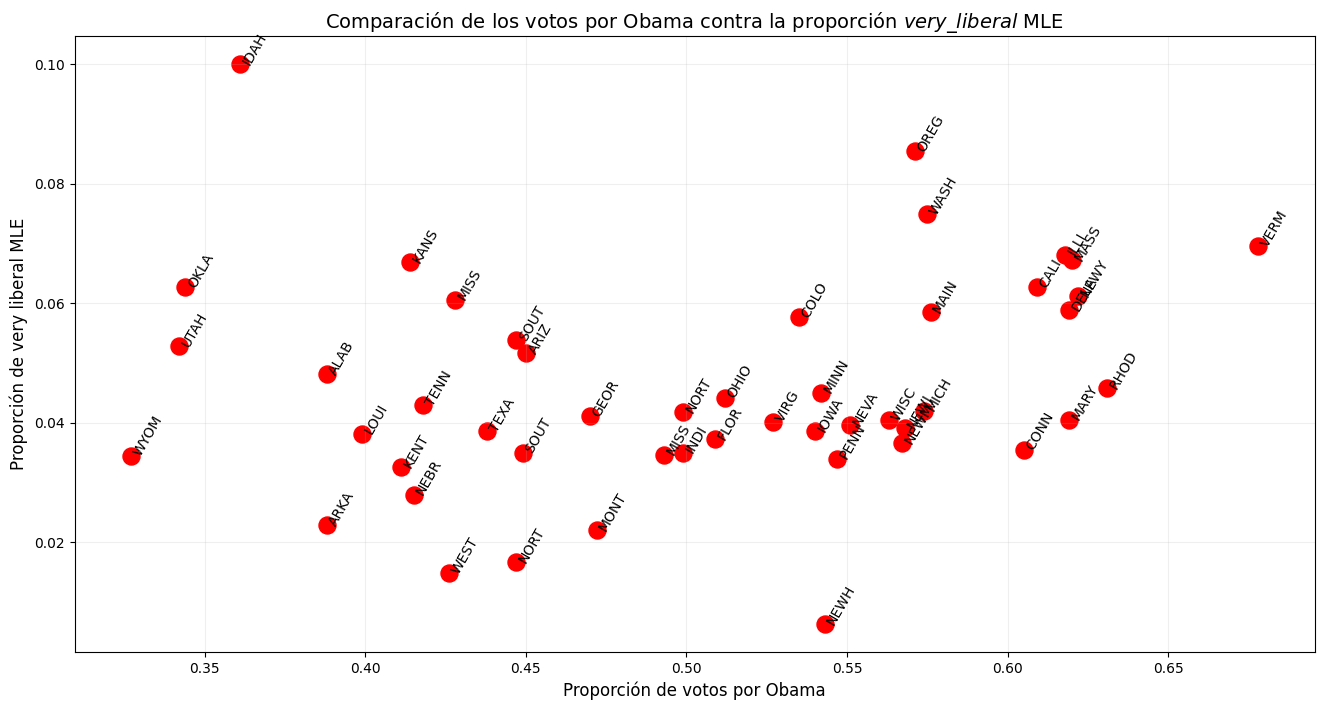

In [4]:
#Carga de datos de las elecciones
results = pd.read_csv('./2008ElectionResult.csv')

#Paso 1: Descartar estados que no son de interés
results = results[~results['state'].isin(['District of Columbia', 'Hawaii', 'Alaska'])]

#Paso 2: Formatear el nombre de los estados para compatibilidad
results['state'] = results['state'].str.lower()

#Paso 3: Se incorpora la información al conjunto de datos
prop = pd.merge(left=prop,
                right=results[['state', 'vote_Obama_pct']],
                how='left',
                on='state')

#Graficando votos por Obama contra proporción very liberal
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_mle'], color='red', s=150)

#Anotaciones y estilo
for idx in prop.index:
    x = prop.loc[idx]['vote_Obama_pct']/100
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=plot_settings['annotation'], rotation=60)
plt.title(r'Comparación de los votos por Obama contra la proporción $very\_liberal$ MLE', fontsize=plot_settings['title'])
plt.xlabel('Proporción de votos por Obama', fontsize=plot_settings['text'])
plt.ylabel('Proporción de very liberal MLE', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)

plt.show()

<div style="text-align: justify">
    
Antes de hablar con detalle de los aspectos interesantes de la visualización anterior, primero hay que aclarar que si bajo este enfoque existiera correlación entre ambas características, entonces se esperaría tener una tendencia creciente hacia arriba a la derecha, es decir, a mayor porcentaje de votos por Obama mayor porcentaje de personas _very liberal_. Esto, como lo hace evidente la gráfica, no sucede.

Dicho lo anterior, se pueden identificar claramente dos regiones tomando como referencia un $50\%$ de votos por Obama. Aproximadamente, desde este valor en adelante existe tendencia creciente en los votos que recibió el candidato, sin embargo, en los estados por debajo de esta referencia, la tendencia es contraria.

Adicionalmente, también existen estados que rompen por completo las aparentes tendencias en dichas regiones. Esto se hace especialmente evidente en estados como Idaho, que presenta la mayor proporción de _very liberal_ pero que en el resultado de las elecciones tuvo menos del $37\%$ de votantes por Obama; o como New Hampshire, que presenta la menor proporción de _very liberal_ de todas, pero que en la elección tuvo casi el $55\%$ de votantes a favor del candidato.

</div>

<div style="text-align: justify">

## Enfoque Bayesiano

Habiendo hablado del enfoque frecuentista, es tiempo de centrarse en el mismo análisis pero desde un punto de vista bayesiano. Sin embargo, antes de adentrarse en el problema, primero es necesario partir de dos ideas fundamentales.

La primera idea es que un enfoque bayesiano se apalanca de dos fuentes de información. Una fuente es el conocimiento que se tiene acerca del problema. Un ejemplo del día a día es aquel en el que se tiene que decidir si llevar paraguas al salir de casa o no. ¿Cómo se toma una decisión al respecto? probablemente se podría voltear a ver al cielo y evaluar si está nublado o soleado, y con base en ello suponer si lloverá o no, sea cual sea el caso, se tiene que tomar una decisión basada en las suposiciones que se tienen del problema. A esta fuente de información se le conoce como **inicial**.

Otra fuente es la información extraída de los datos que se tienen del problema. En el ejemplo de la lluvia, si se cuenta con datos meteorológicos que indican que se está en temporada de lluvias y a una hora determinada está indicado que lloverá, entonces lo más probable es que llueva. En este punto es en donde se conectan ambos enfoques, ya que esta fuente de información es la **máxima verosimilitud** vista en la sección anterior.

La segunda idea es que en el mundo bayesiano, el conocimiento final o posterior será un punto intermedio entre las dos fuentes de información anteriores, es decir, la inicial y la verosimilitud. Dependiendo de qué tanta relevancia tenga cada una de ellas, será el qué tanto el conocimiento posterior se cargará hacia una u otra.

Sabiendo lo anterior la pregunta natural sería entonces ¿cómo se controla la relevancia de la información?, y como en casi todos los problemas de analítica, la respuesta depende del contexto del problema:

* Si se tienen mucha confianza en la información inicial (por ejemplo una distribución normal con alta curtosis y poca varianza), entonces se trata de un problema con una inicial muy relevante, por ende, la verosimilitud necesitará una gran cantidad de datos para poder moverla.
* Si por el contrario se tiene poca confianza en la información inicial (por ejemplo una distribución uniforme), entonces se trata de un problema con poca relevancia en la inicial, por ende, no tomarán demasiados datos para que la verosimilitud la desplace.

Para ilustrarlo se retoma entonces el problema de Obama, en particular, utilizando la familia conjugada binomial-beta. Esta familia tiene la gentileza de que, para un conocimiento inicial distribuido beta de un fenómeno que se distribuye binomial, el conocimiento posterior también es distribuido beta pero con parámetros ajustados (Las ecuaciones de estos nuevos parámetros se muestran en el Anexo 2). Cabe aclarar que, para esta primera comparación, utilizar una familia conjugada es con propósitos estrictamente ilustrativos, formalmente debería utilizarse un modelo jerárquico. Dicho eso, se puede visualizar la distribución de personas con ideología _very liberal_ obtenidas con un enfoque frecuentista.
    
</div>

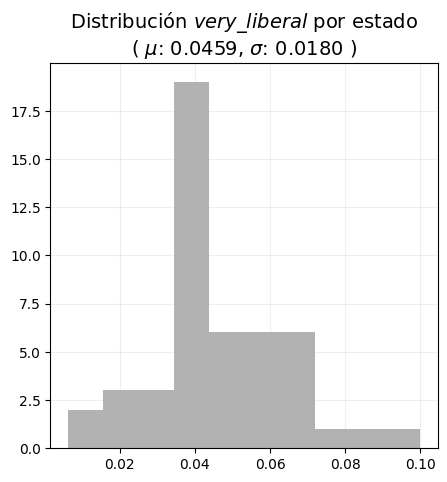

In [5]:
m = prop['prop_mle'].mean()
s2 = prop['prop_mle'].var()

fig, ax = plt.subplots(figsize=(5,5))

plt.hist(x=prop['prop_mle'], color='grey', alpha=0.6)
plt.title(f"Distribución $very\_liberal$ por estado\n( $\mu$: {m:.4f}, $\sigma$: {np.sqrt(s2):.4f} )", fontsize=plot_settings['title'])
plt.grid(alpha=0.2)

plt.show()

<div style="text-align: justify">

En este caso, lo que se observa es que la distribución de personas de cada estado que se identifican _very liberal_ bajo un enfoque frecuentista, tiene una media de $\mu\approx 0.045$ y desviación estándar $\sigma\approx 0.018$. Se podría retomar la intuición de la sección anterior, es decir, cada uno de los estados es una representación del comportamiento general de todo el país, en donde el comportamiento general estaría centrado en $\mu= 0.0459$.

La idea en la que cada estado varía en mayor o menor medida de un valor central representa entonces el conocimiento inicial, queda definir su relevancia. En este caso, la relevancia queda dada por la desviación estándar de los datos, entre menor sea la desviación mayor será la influencia de la inicial sobre la posterior y viceversa. Se puede observar el efecto de la relevancia de la inicial comparando diferentes valores de $\sigma$, para ello, arbitrariamente se puede escoger un estado (por ejemplo Idaho), y se va a utilizar como referencia la desviación de la gráfica anterior, es decir, $\sigma=0.018$.

</div>

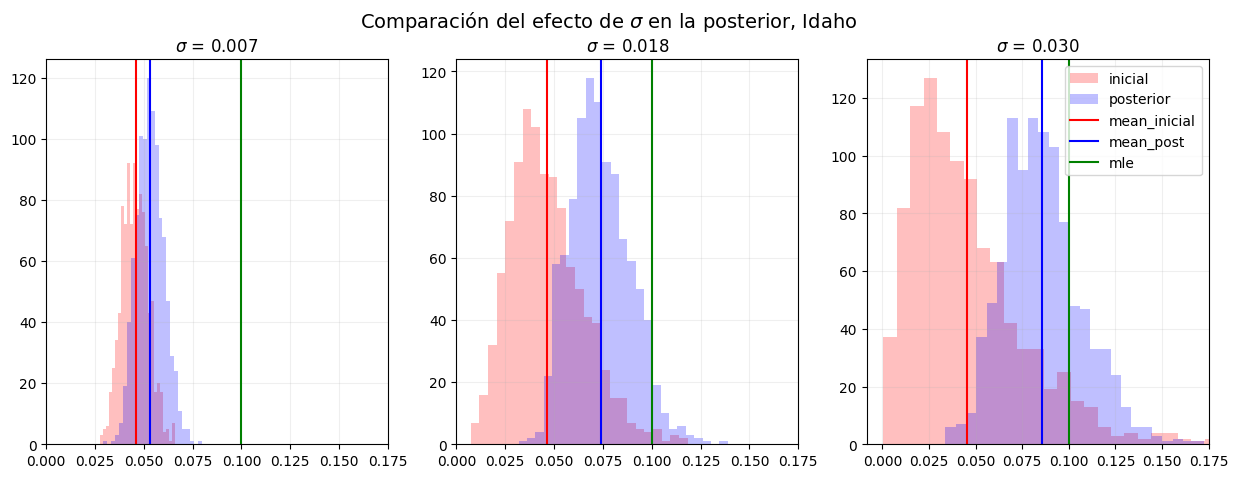

In [6]:
#Función para obtener parámetros de beta posterior
def get_beta_params(mu, var): 
    a = mu * (-mu**2 + mu - var) / var
    b = (mu - 1) * (mu**2 - mu + var) / var
    return [a, b]

#Parámetros de simulación
sims = 1_000
var_list = [0.007**2, s2, 0.03**2]
k = len(var_list)

#Parámetros de estado
state = prop.loc[9]['state']
n = prop.loc[9]['survey_total']
x = prop.loc[9]['survey_very_lib']

#Parámetros de figura
fig = plt.figure(figsize=(15,5))
spec = plt.GridSpec(ncols=k, nrows=1, hspace=0.3)
ticks = np.arange(0, 0.18, 0.025)

for idx in range(k):
    #Parámetros de beta
    a, b = get_beta_params(m, var_list[idx])
    
    #Distribución inicial
    inicial = beta.rvs(a=a, b=b, size=sims)
    inicial_mean = inicial.mean()
    
    #Distribución posterior
    posterior = beta.rvs(a=(a+x), b=(b+n-x), size=sims)
    
    #Gráficas
    ax_n = f"ax{idx}"
    ax_n = fig.add_subplot(spec[idx])
    ax_n.hist(x=inicial, bins=25, color='red', alpha=0.25, label='inicial')
    ax_n.hist(x=posterior, bins=25, color='blue', alpha=0.25, label='posterior')
    ax_n.axvline(x=inicial.mean(), color='red', label='mean_inicial')
    ax_n.axvline(x=posterior.mean(), color='blue', label='mean_post')
    ax_n.axvline(x=prop.loc[9]['prop_mle'], color='green', label='mle')
    
    #Anotaciones y estilo
    ax_n.set_title(f"$\sigma$ = {np.sqrt(var_list[idx]):.3f}", fontsize=plot_settings['text'])
    ax_n.set_xlim(right=ticks.max())
    ax_n.set_xticks(ticks)
    ax_n.grid(alpha=0.2)

#Anotaciones generales
plt.suptitle(f"Comparación del efecto de $\sigma$ en la posterior, {state.title()}", fontsize=plot_settings['title'])
plt.legend()
plt.show()

<div style="text-align: justify">

De la visualización anterior es importante resaltar que, para todos los gráficos del panel, tanto la proporción de máxima verosimilitud (Línea verde) como la media de la inicial (Línea roja) toman los mismos valores. Sin embargo, se observa que efectivamente, la inicial tiene mayor peso sobre la posterior a menor desviación estándar. Esto se ve tanto en la posición como en la dispersión de la posterior:

* Para una desviación estándar $\sigma=0.007$, la media de la posterior se encuentra aproximadamente en $0.05$, mucho más cercana al valor de la inicial.
* Para la desviación estándar de referencia $\sigma=0.018$, la media de la posterior es cercana a $0.075$, aproximadamente a la mitad entre la inicial y la verosimilitud.
* Para una desviación estándar $\sigma=0.03$, la media de la posterior se encuentra aproximadamente en $0.08$, mucho más cercana al valor de la verosimilitud.

Ahora bien, una vez entendida la lógica detrás del enfoque bayesiano aplicado en un único estado, es tiempo de regresar al valor de referencia $\sigma=0.018$ y visualizar el comportamiento de todos los estados. Para ello, primero se pueden describir 9 estados de interés.

</div>

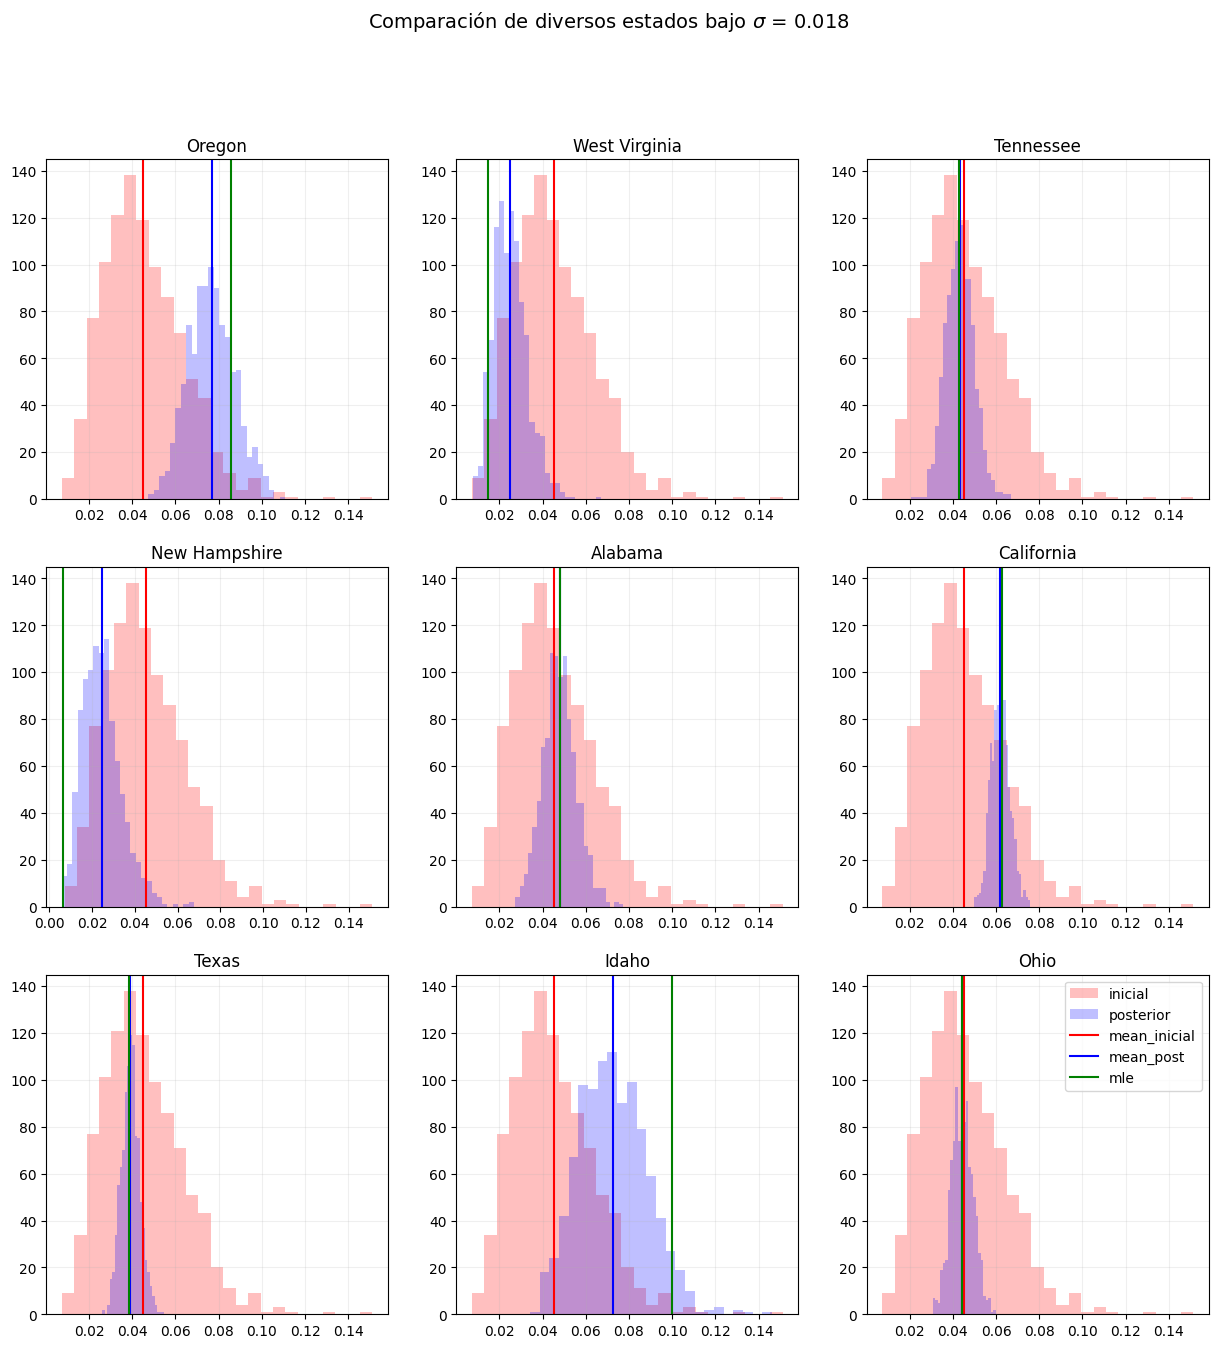

In [7]:
#Parámetros de beta
a, b = get_beta_params(m, s2)

#Parámetros de simulación
sims = 1_000
inicial = beta.rvs(a=a, b=b, size=sims)
inicial_mean = inicial.mean()

#Parámetros de panel
panels = 3
states_idx = [34,45,39,26,0,3,40,9,32]

#Parámetros de figura
fig = plt.figure(figsize=(15,15))
spec = plt.GridSpec(ncols=panels, nrows=panels)
k = 0
for idx in states_idx:
    state = prop.loc[idx]['state']
    
    #Cálculo de la posterior
    n = prop.loc[idx]['survey_total']
    x = prop.loc[idx]['survey_very_lib']
    posterior = beta.rvs(a=(a+x), b=(b+n-x), size=sims)
    
    #Gráficas
    ax_n = f"ax{k}"
    ax_n = fig.add_subplot(spec[k])
    ax_n.hist(x=inicial, bins=25, color='red', alpha=0.25, label='inicial')
    ax_n.hist(x=posterior, bins=25, color='blue', alpha=0.25, label='posterior')
    ax_n.axvline(x=inicial.mean(), color='red', label='mean_inicial')
    ax_n.axvline(x=posterior.mean(), color='blue', label='mean_post')
    ax_n.axvline(x=prop.loc[idx]['prop_mle'], color='green', label='mle')
    
    #Anotaciones y estilo
    ax_n.set_title(state.title(), fontsize=plot_settings['text'])
    ax_n.grid(alpha=0.2)
    
    k += 1

#Anotaciones generales.
plt.suptitle(f"Comparación de diversos estados bajo $\sigma$ = {np.sqrt(s2):.3f}", fontsize=plot_settings['title'])
plt.legend()
plt.show()

<div style="text-align: justify">
    
La relevancia del panel anterior radica en que se puede ver con claridad el efecto de la inicial, que parte de ser la misma para todos los estados. Al considerarlo de esta manera, se está modelando el comportamiento promedio del país sobre cada uno de los estados, sin embargo, al haber modelado la verosimilitud de cada estado de manera independiente, se puede ver que la posterior de cada uno tiene comportamientos distintos dependiendo de varios posibles factores. Tomando como referencia la media de la verosimilitud (Línea verde), entonces:

* Si la verosimilitud está por debajo de la inicial, entonces la posterior se mueve hacia la derecha, como es el caso de New Hampshire o West Virginia.
* Por el contrario, si la verismilitud es mayor a la inicial entonces la posterior se recorre hacia la izquierda, como es el caso de Oregon o Idaho.
* Si se trata de un estado con poca represantación en las encuestas, entonces la inicial desplaza considerablemente a la posterior dejándola aproximadamente a la mitad, como es el caso de Idaho o New Hampshire.
* En contraste, si se trata de un estado con mucha representación en las encuestas, entonces la inicial no tiene gran efecto sobre la posterior dejándola muy parecida a la verosimilitud, como es el caso de California o Texas.
* Finalmente, cuando tanto la inicial como la verosimilitud son muy parecidas, entonces la posterior también lo es independientemente de su representación en las encuestas, como es el caso de Ohio, Alabama, o Tennessee.

Así pues, nuevamente se visualiza la proporción de votos que tuvo Obama contra la proporción de _very liberal_ por estado, en esta ocasión utilizando ambos enfoques.

</div>

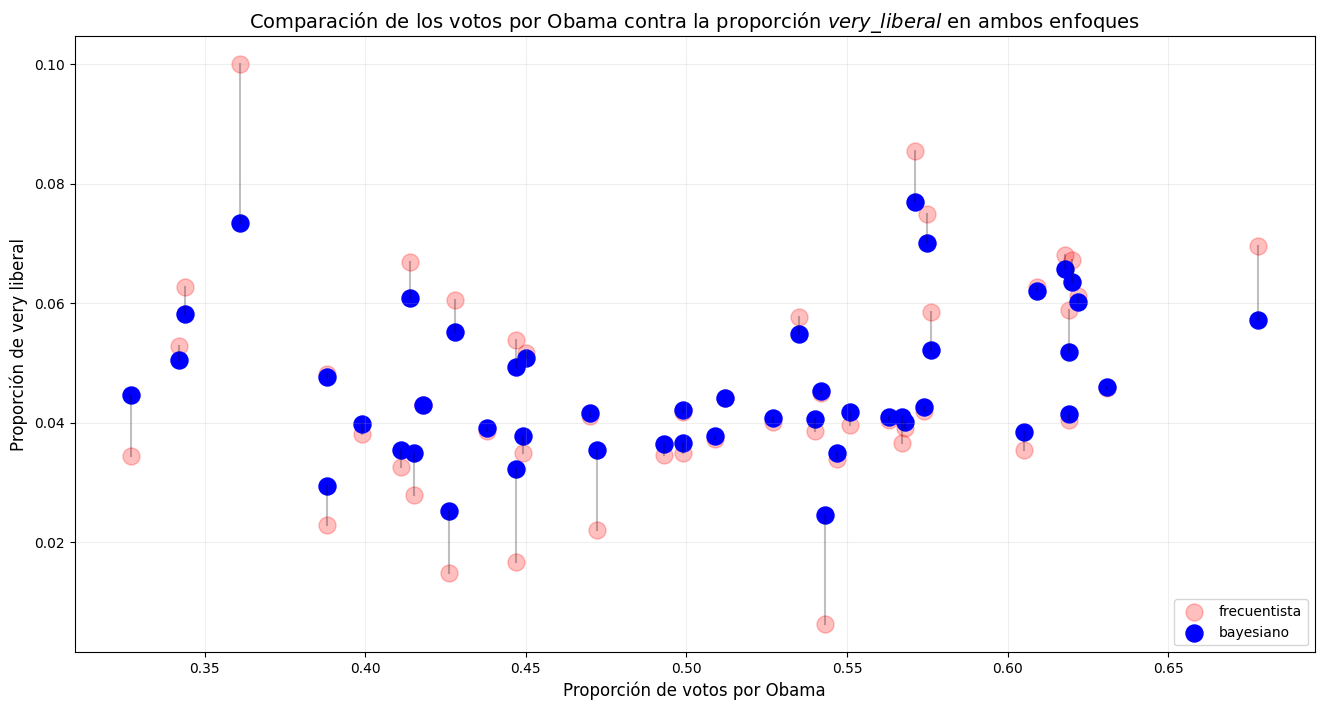

In [8]:
#Se crea columna vacía en dataframe
prop['prop_bayes'] = np.nan

for idx in prop.index:
    #Cálculo de la posterior
    n = prop.loc[idx]['survey_total']
    x = prop.loc[idx]['survey_very_lib']
    posterior_mean = beta.rvs(a=(a+x), b=(b+n-x), size=sims).mean()
    
    prop.loc[prop.index == idx, 'prop_bayes'] = posterior_mean

#Graficando desplazamientos
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_mle'], color='red', s=150, label='frecuentista', alpha=0.25)
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_bayes'], color='blue', s=150, label='bayesiano')
for idx in prop.index:
    x = prop.loc[idx]['vote_Obama_pct']/100
    y_mle = prop.loc[idx]['prop_mle']
    y_bayes = prop.loc[idx]['prop_bayes']
    plt.plot([x,x], [y_mle, y_bayes], color='black', alpha=0.25)

#Anotaciones y estilo
plt.title(r'Comparación de los votos por Obama contra la proporción $very\_liberal$ en ambos enfoques', fontsize=plot_settings['title'])
plt.xlabel('Proporción de votos por Obama', fontsize=plot_settings['text'])
plt.ylabel('Proporción de very liberal', fontsize=plot_settings['text'])
plt.legend(fontsize=plot_settings['annotation'], loc=4)
plt.grid(alpha=0.2)

plt.show()

<div style="text-align: justify">

Lo primero que se puede notar, es que bajo el enfoque bayesiano se reduce la dispersión de los puntos, manifestando un comportamiento relativamente más centrado en torno a un valor de referencia en $\mu=0.045$, esto tiene sentido debido a que este enfoque partió de considerar la misma proporción de _very liberal_ en todos los estados. Adicionalmente, de nueva cuenta se vuelve evidente que los estados que más desplazamiento sufrieron, fueron aquellos que tenían poca representación en las encuestas, o que originalmente se encontraban más alejados del valor de la inicial. Los estados que estaban por encima de $\mu$ bajaron, y los que se encontraban por debajo subieron.

## Finalmente
    
Con este sencillo ejemplo es posible darse cuenta de las diferencias que hay entre ambos enfoques. Al mismo tiempo, también se puede indentificar el enorme potencial que tiene un enfoque bayesiano ya que, en principio, incorpora mayor cantidad de información al respecto de un tema, no nada más los datos. Sin embargo, esta propiedad que en principio puediera ser una virtud, también es el punto débil del mundo bayesiano, debido a que si la información inicial es incorrecta o está sesgada hacia alguna opinión parcial, se puede caer en errores sumamente graves o tendenciosos. Es precisamente en este punto en el que está la mayor crítica a los enfoques bayesianos.

</div>

---

<div style="text-align: justify">

## Anexo 1

Máxima verosimilitud de una distribución binomial ($n=1$):

Sean $X = \{x_1,x_2,...,x_n\}$ muestras de una variable aleatoria independiente e idénticamente distribuida que siguen una distribución $x_i \backsim B(k=1, p=\theta)$ siendo $k$ el número de repeticiones del experimento, entonces:

Probabilidad: 

$$P(x_i|\theta)=\binom{1}{x_i}\theta^{x_i}(1-\theta)^{1-x_i}=\theta^{x_i}(1-\theta)^{1-x_i}$$

Verosimilitud:

$$L(\theta|X)=\prod_{i=1}^n P(x_i|\theta)=\prod_{i=1}^n\left[\theta^{x_i}(1-\theta)^{1-x_i}\right]$$

Log-verosimilitud:

$$ln[L(\theta|X)]=\sum_{i=1}^nln\left[\theta^{x_i}(1-\theta)^{1-x_i}\right]=ln\theta\sum x_i+ln(1-\theta)\sum(1-x_i)$$

Derivando e igualando a cero:

$$\frac{\partial}{\partial\theta}ln[L(\theta|X)]=\frac{1}{\theta}\sum x_i-\frac{1}{1-\theta}\sum(1-x_i)=0$$

$$(1-\theta)\sum x_i-\theta\sum(1-x_i)=0$$

$$\sum x_i - \theta n  = 0$$

$$\therefore\theta=\frac{1}{n}\sum_{i=1}^n x_i=\bar x$$

Es decir:

$$\theta=\bar x$$

## Anexo 2

Utilizando el módulo de python `sympy` para cálculo simbólico, se obtuvieron las ecuaciones que resulven los parámetros $a$, $b$ de una distribución conjugada beta-binomial dados los valores de $\mu$, $\sigma$.
    
</div>

In [9]:
from sympy import symbols, Eq, solve
from sympy.abc import mu, sigma

a, b, s2, m = symbols("a b sigma^2 mu")

equation_1 = Eq( a / (a+b), m )
equation_2 = Eq( a*b / ((a+b)**2 * (a + b + 1)), s2 )
solution = solve((equation_1, equation_2), (a, b))

equation_1

Eq(a/(a + b), mu)

In [10]:
equation_2

Eq(a*b/((a + b)**2*(a + b + 1)), sigma^2)

In [11]:
print("Solución para el parámetro 'a':\n")
solution[0][0]

Solución para el parámetro 'a':



mu*(-mu**2 + mu - sigma^2)/sigma^2

In [12]:
print("Solución para el parámetro 'b':\n")
solution[0][1]

Solución para el parámetro 'b':



(mu - 1)*(mu**2 - mu + sigma^2)/sigma^2

Las expresiones anteriores se puegen programar directamente en una función de python

---